In [1]:
# from IPython.core.display import display, HTML

import pandas as pd
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import os
import gc

from joblib import Parallel, delayed

from sklearn import preprocessing, model_selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt 
import seaborn as sns
import numpy.matlib
from catboost import Pool, CatBoostRegressor


# path_submissions = '/'
# target_name = 'target'
# scores_folds = {}

In [2]:
# data directory
data_dir = '../input/optiver-realized-volatility-prediction/'


# My function 
def BidAskSpread(df):
    return ((df['ask_price1']/df['bid_price1'])-1)
def Wap1(df):
    return (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (df['bid_size1'] + df['ask_size1'])
def Wap2(df):
    return (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']) / (df['bid_size2'] + df['ask_size2'])
def Wap3(df):
    return (df['bid_price1'] * df['bid_size1'] + df['ask_price1'] * df['ask_size1']) / (df['bid_size1'] + df['ask_size1'])
def Wap4(df):
    return (df['bid_price2'] * df['bid_size2'] + df['ask_price2'] * df['ask_size2']) / (df['bid_size2'] + df['ask_size2'])

def count_unique(series):
    return len(np.unique(series))

def BidAsk_price_gap(df):
    return (df['ask_price1']-df['bid_price1'])
def BidAsk_price_center(df):
    return ((df['ask_price1']+df['bid_price1'])/2)

def BidAsk_size_gap(df):
    return (abs(df['ask_size1']-df['bid_size1']))
def BidAsk_size_center(df):
    return ((df['ask_size1']+df['bid_size1'])/2)
 
def BidAsk_Weighted_center(df):
    gap= df['ask_price1']-df['bid_price1']
    center= ((df['ask_price1']+df['bid_price1'])/2)
    add_weight=abs((df['ask_price1']-center)*df['ask_size1'])
    mins_weight=abs((df['bid_price1']-center)*df['bid_size1'])
    weight_center=center+gap*(add_weight-mins_weight)/(add_weight+mins_weight)
    return (weight_center)
def Bid_spread(df):
    return (df['bid_price1'] - df['bid_price2'])
def Ask_spread(df):
    return (abs(df['ask_price1'] - df['ask_price2']))
def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))
# Add feature
def BidAsk_size12_gap(df):
    return (abs(df['ask_size1']+df['ask_size2']-df['bid_size1']-df['bid_size2']))
def Wap12(df):
    return (df['bid_price1'] * df['ask_size1'] + df['ask_price2'] * df['bid_size2']) / (df['bid_size1'] + df['ask_size2'])
def Wap21(df):
    return (df['bid_price2'] * df['ask_size2'] + df['ask_price1'] * df['bid_size1']) / (df['bid_size2'] + df['ask_size1'])
def BidAskSpread12(df):
    return ((df['ask_price1']/df['bid_price2'])-1)
def BidAskSpread21(df):
    return ((df['ask_price2']/df['bid_price2'])-1)
def BidAsk_size_add_gap(df):
    return (abs(df['ask_size1']+df['ask_size2']-df['bid_size1']-df['bid_size2']))


def bid_size_weight(df):
    return np.sqrt((np.square(df['bid_size1'])+np.square(df['bid_size2']))/(np.square(df['bid_size1'])+np.square(df['bid_size2'])+np.square(df['ask_size1'])+np.square(df['ask_size2'])))

def ask_size_weight(df):
    return np.sqrt((np.square(df['ask_size1'])+np.square(df['ask_size2']))/(np.square(df['bid_size1'])+np.square(df['bid_size2'])+np.square(df['ask_size1'])+np.square(df['ask_size2'])))




def total_diff_size(df):
    return  (abs((df['ask_size1'] + df['ask_size2']) - (df['bid_size1'] + df['bid_size2'])))
def total_size(df):
    return  (abs((df['ask_size1'] + df['ask_size2']) + (df['bid_size1'] + df['bid_size2'])))
def price_spread(df):
    return (df['ask_price1'] - df['bid_price1']) / ((df['ask_price1'] + df['bid_price1']) / 2)
def price_spread2(df):
    return (df['ask_price2'] - df['bid_price2']) / ((df['ask_price2'] + df['bid_price2']) / 2) 



# Function to calculate the log of the return
# Remember that logb(x / y) = logb(x) - logb(y)
def log_return(series):
    return np.log(series).diff()

# Calculate the realized volatility
def realized_volatility(series):
    return np.sqrt(np.sum(series**2))

# Function to count unique elements of a series
def count_unique(series):
    return len(np.unique(series))



# Function to read our base train and test set
def read_train_test():
    train = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
    test = pd.read_csv('../input/optiver-realized-volatility-prediction/test.csv')
    # Create a key to merge with book and trade data
    train['row_id'] = train['stock_id'].astype(str) + '-' + train['time_id'].astype(str)
    test['row_id'] = test['stock_id'].astype(str) + '-' + test['time_id'].astype(str)
    #print(f'Our training set has {train.shape[0]} rows')
    return train,test

# Function to preprocess book data (for each stock id)
def book_preprocessor(file_path):
    df = pd.read_parquet(file_path)
    # Calculate Wap
    df['wap1'] = Wap1(df)
    df['wap2'] = Wap2(df)
    df['wap3'] = Wap3(df)
    df['wap4'] = Wap4(df)
    
    df['BidAsk_price_gap'] = BidAsk_price_gap(df)
    df['BidAsk_price_center'] = BidAsk_price_center(df)
    df['BidAsk_size_gap'] = BidAsk_size_gap(df)
    df['BidAsk_size_center'] = BidAsk_size_center(df)
    df['BidAsk_Weighted_center'] = BidAsk_Weighted_center(df)
    df['Bid_spread'] = Bid_spread(df)
    df['Ask_spread'] = Ask_spread(df)
#     df['Wap12'] = Wap12(df)
#     df['Wap21'] = Wap21(df)
    
    df['BidAsk_size12_gap'] = BidAsk_size12_gap(df)   
    df['Wap12'] = Wap12(df)    
    df['Wap21'] = Wap21(df)    
    df['BidAskSpread12'] = BidAskSpread12(df)    
    df['BidAskSpread21'] = BidAskSpread21(df)    

    df['BidAskSpread'] = BidAskSpread(df)
    df['BidAsk_size_add_gap'] = BidAsk_size_add_gap(df) 
    df['bid_size_weight'] = bid_size_weight(df) 
    df['ask_size_weight'] = ask_size_weight(df) 
    #
    df['total_diff_size'] = total_diff_size(df) 
    df['total_size'] = total_size(df) 
    df['price_spread'] = price_spread(df) 
    df['price_spread2'] = price_spread2(df) 
    # Calculate log returns
    df['log_return1'] = df.groupby(['time_id'])['wap1'].apply(log_return)
    df['log_return2'] = df.groupby(['time_id'])['wap2'].apply(log_return)
    df['log_return3'] = df.groupby(['time_id'])['wap3'].apply(log_return)
    df['log_return4'] = df.groupby(['time_id'])['wap4'].apply(log_return)
    df['log_return12'] = df.groupby(['time_id'])['Wap12'].apply(log_return)
    df['log_return21'] = df.groupby(['time_id'])['Wap21'].apply(log_return)
    
    # Calculate wap balance
    df['wap_balance'] = abs(df['wap1'] - df['wap2'])
    
    # Dict for aggregations
    create_feature_dict = {
        'wap1': [np.sum, np.std],
        'wap2': [np.sum, np.std],
        'wap3': [np.sum, np.std],
        'wap4': [np.sum, np.std],
        'Wap12': [np.sum, np.std],
        'Wap21': [np.sum, np.std],
        
        
        'BidAsk_price_gap': [np.mean, np.std],
        'BidAsk_size_gap': [np.mean, np.std],
        'BidAsk_size_center': [np.mean, np.std],
        'BidAsk_Weighted_center': [np.mean, np.std],
        'BidAsk_price_center': [np.mean, np.std],

        
        'log_return1': [realized_volatility],
        'log_return2': [realized_volatility],
        'log_return3': [realized_volatility],
        'log_return4': [realized_volatility],
        
        'BidAsk_size12_gap': [np.sum, np.std],
        'BidAskSpread12': [np.sum, np.max],
        'BidAskSpread21': [np.sum, np.max],
        
        
        'BidAsk_size_add_gap': [np.sum, np.max],
#         'BidAskSpread21': [np.sum, np.max,np.min],
        'bid_size_weight': [np.sum, np.max],
        'ask_size_weight': [np.sum, np.max],
        

        'wap_balance': [np.sum, np.max],
        'price_spread':[np.sum, np.max],
        'price_spread2':[np.sum, np.max],
        'Bid_spread':[np.sum, np.max],
        'Ask_spread':[np.sum, np.max],
        'total_size':[np.sum, np.max],
        'total_diff_size':[np.sum, np.max],
        "BidAskSpread":[np.sum, np.max],
    }
    create_feature_dict_time = {
        'log_return1': [realized_volatility],
        'log_return2': [realized_volatility],
        'log_return3': [realized_volatility],
        'log_return4': [realized_volatility],
        'log_return12': [realized_volatility],
        'log_return21': [realized_volatility],
    }
    
    # Function to get group stats for different windows (seconds in bucket)
    def get_stats_window(fe_dict,seconds_in_bucket, add_suffix = False):
        # Group by the window
        df_feature = df[df['seconds_in_bucket'] >= seconds_in_bucket].groupby(['time_id']).agg(fe_dict).reset_index()
        # Rename columns joining suffix
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        # Add a suffix to differentiate windows
        if add_suffix:
            df_feature = df_feature.add_suffix('_' + str(seconds_in_bucket))
        return df_feature
    
    def get_stats_window_re(fe_dict,seconds_in_bucket, add_suffix = False):
        # Group by the window
        df_feature = df[df['seconds_in_bucket'] <= seconds_in_bucket].groupby(['time_id']).agg(fe_dict).reset_index()
        # Rename columns joining suffix
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        # Add a suffix to differentiate windows
        if add_suffix:
            df_feature = df_feature.add_suffix('_' + str(seconds_in_bucket))
        return df_feature
    
    # Get the stats for different windows
    df_feature = get_stats_window(create_feature_dict,seconds_in_bucket = 0, add_suffix = False)
    df_feature_500 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 500, add_suffix = True)
#     df_feature_450 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 450, add_suffix = True)
    df_feature_400 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 400, add_suffix = True)
#     df_feature_350 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 350, add_suffix = True)
    df_feature_300 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 300, add_suffix = True)
#     df_feature_250 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 250, add_suffix = True)
    df_feature_200 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 200, add_suffix = True)
#     df_feature_150 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 150, add_suffix = True)
    df_feature_100 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 100, add_suffix = True)
#     df_feature_50 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 50, add_suffix = True)
    # Get the stats for different windows
#     df_feature = get_stats_window_re(create_feature_dict,seconds_in_bucket = 0, add_suffix = False)
    df_feature_500_re = get_stats_window_re(create_feature_dict_time,seconds_in_bucket = 500, add_suffix = True)
#     df_feature_450_re = get_stats_window_re(create_feature_dict_time,seconds_in_bucket = 450, add_suffix = True)
    df_feature_400_re = get_stats_window_re(create_feature_dict_time,seconds_in_bucket = 400, add_suffix = True)
#     df_feature_350_re = get_stats_window_re(create_feature_dict_time,seconds_in_bucket = 350, add_suffix = True)
    df_feature_300_re = get_stats_window_re(create_feature_dict_time,seconds_in_bucket = 300, add_suffix = True)
#     df_feature_250_re = get_stats_window_re(create_feature_dict_time,seconds_in_bucket = 250, add_suffix = True)
    df_feature_200_re = get_stats_window_re(create_feature_dict_time,seconds_in_bucket = 200, add_suffix = True)
#     df_feature_150_re = get_stats_window_re(create_feature_dict_time,seconds_in_bucket = 150, add_suffix = True)
    df_feature_100_re = get_stats_window_re(create_feature_dict_time,seconds_in_bucket = 100, add_suffix = True)
#     df_feature_50_re = get_stats_window_re(create_feature_dict_time,seconds_in_bucket = 50, add_suffix = True)
    
    
    # Merge all
    df_feature = df_feature.merge(df_feature_500, how = 'left', left_on = 'time_id_', right_on = 'time_id__500')
#     df_feature = df_feature.merge(df_feature_450, how = 'left', left_on = 'time_id_', right_on = 'time_id__450')
    df_feature = df_feature.merge(df_feature_400, how = 'left', left_on = 'time_id_', right_on = 'time_id__400')
#     df_feature = df_feature.merge(df_feature_350, how = 'left', left_on = 'time_id_', right_on = 'time_id__350')
    df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
#     df_feature = df_feature.merge(df_feature_250, how = 'left', left_on = 'time_id_', right_on = 'time_id__250')
    df_feature = df_feature.merge(df_feature_200, how = 'left', left_on = 'time_id_', right_on = 'time_id__200')
#     df_feature = df_feature.merge(df_feature_150, how = 'left', left_on = 'time_id_', right_on = 'time_id__150')
    df_feature = df_feature.merge(df_feature_100, how = 'left', left_on = 'time_id_', right_on = 'time_id__100')
#     df_feature = df_feature.merge(df_feature_50, how = 'left', left_on = 'time_id_', right_on = 'time_id__50')
    # Drop unnecesary time_ids
#     df_feature.drop(['time_id__500','time_id__450','time_id__400','time_id__350', 'time_id__300','time_id__250', 'time_id__200','time_id__150','time_id__100','time_id__50'], axis = 1, inplace = True)
    df_feature.drop(['time_id__500','time_id__400', 'time_id__300', 'time_id__200','time_id__100'], axis = 1, inplace = True)
    ##############################################################################################################

#     df_feature.drop(['time_id__500','time_id__450','time_id__400','time_id__350', 'time_id__300','time_id__250', 'time_id__200','time_id__150','time_id__100','time_id__50'], axis = 1, inplace = True)
    # Merge all
    df_feature = df_feature.merge(df_feature_500_re, how = 'left', left_on = 'time_id_', right_on = 'time_id__500')
#     df_feature = df_feature.merge(df_feature_450_re, how = 'left', left_on = 'time_id_', right_on = 'time_id__450')
    df_feature = df_feature.merge(df_feature_400_re, how = 'left', left_on = 'time_id_', right_on = 'time_id__400')
#     df_feature = df_feature.merge(df_feature_350_re, how = 'left', left_on = 'time_id_', right_on = 'time_id__350')
    df_feature = df_feature.merge(df_feature_300_re, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
#     df_feature = df_feature.merge(df_feature_250_re, how = 'left', left_on = 'time_id_', right_on = 'time_id__250')
    df_feature = df_feature.merge(df_feature_200_re, how = 'left', left_on = 'time_id_', right_on = 'time_id__200')
#     df_feature = df_feature.merge(df_feature_150_re, how = 'left', left_on = 'time_id_', right_on = 'time_id__150')
    df_feature = df_feature.merge(df_feature_100_re, how = 'left', left_on = 'time_id_', right_on = 'time_id__100')
#     df_feature = df_feature.merge(df_feature_50_re, how = 'left', left_on = 'time_id_', right_on = 'time_id__50')
    # Drop unnecesary time_ids
    df_feature.drop(['time_id__500','time_id__400', 'time_id__300', 'time_id__200','time_id__100'], axis = 1, inplace = True)
    
    # Create row_id so we can merge
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['time_id_'].apply(lambda x: f'{stock_id}-{x}')
    df_feature.drop(['time_id_'], axis = 1, inplace = True)
    return df_feature

# Function to preprocess trade data (for each stock id)
def trade_preprocessor(file_path):
    df = pd.read_parquet(file_path)
    df['log_return'] = df.groupby('time_id')['price'].apply(log_return)
    df['amount']=df['price']*df['size']
    # Dict for aggregations
    create_feature_dict = {
        'log_return':[realized_volatility],
        'seconds_in_bucket':[count_unique],
        'size':[np.sum, np.max, np.min],
        'order_count':[np.sum,np.max,np.min],
        'amount':[np.sum,np.max,np.min],
    }
    create_feature_dict_time = {
        'log_return':[realized_volatility],
        'seconds_in_bucket':[count_unique],
        'size':[np.sum],
        'order_count':[np.sum],
    }
    # Function to get group stats for different windows (seconds in bucket)
    def get_stats_window(fe_dict,seconds_in_bucket, add_suffix = False):
        # Group by the window
        df_feature = df[df['seconds_in_bucket'] >= seconds_in_bucket].groupby(['time_id']).agg(fe_dict).reset_index()
        # Rename columns joining suffix
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        # Add a suffix to differentiate windows
        if add_suffix:
            df_feature = df_feature.add_suffix('_' + str(seconds_in_bucket))
        return df_feature
    

    # Get the stats for different windows
    df_feature = get_stats_window(create_feature_dict,seconds_in_bucket = 0, add_suffix = False)
    df_feature_500 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 500, add_suffix = True)
#     df_feature_450 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 450, add_suffix = True)
    df_feature_400 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 400, add_suffix = True)
#     df_feature_350 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 350, add_suffix = True)
    df_feature_300 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 300, add_suffix = True)
#     df_feature_250 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 250, add_suffix = True)
    df_feature_200 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 200, add_suffix = True)
#     df_feature_150 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 150, add_suffix = True)
    df_feature_100 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 100, add_suffix = True)
#     df_feature_50 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 50, add_suffix = True)
    
    def tendency(price, vol):    
        df_diff = np.diff(price)
        val = (df_diff/price[1:])*100
        power = np.sum(val*vol[1:])
        return(power)
    
    lis = []
    for n_time_id in df['time_id'].unique():
        df_id = df[df['time_id'] == n_time_id]        
        tendencyV = tendency(df_id['price'].values, df_id['size'].values)      
        f_max = np.sum(df_id['price'].values > np.mean(df_id['price'].values))
        f_min = np.sum(df_id['price'].values < np.mean(df_id['price'].values))
        df_max =  np.sum(np.diff(df_id['price'].values) > 0)
        df_min =  np.sum(np.diff(df_id['price'].values) < 0)
        # new
        abs_diff = np.median(np.abs( df_id['price'].values - np.mean(df_id['price'].values)))        
        energy = np.mean(df_id['price'].values**2)
        iqr_p = np.percentile(df_id['price'].values,75) - np.percentile(df_id['price'].values,25)
        
        # vol vars
        
        abs_diff_v = np.median(np.abs( df_id['size'].values - np.mean(df_id['size'].values)))        
        energy_v = np.sum(df_id['size'].values**2)
        iqr_p_v = np.percentile(df_id['size'].values,75) - np.percentile(df_id['size'].values,25)
        
        lis.append({'time_id':n_time_id,'tendency':tendencyV,'f_max':f_max,'f_min':f_min,'df_max':df_max,'df_min':df_min,
                   'abs_diff':abs_diff,'energy':energy,'iqr_p':iqr_p,'abs_diff_v':abs_diff_v,'energy_v':energy_v,'iqr_p_v':iqr_p_v})
    
    df_lr = pd.DataFrame(lis)
        
   
    df_feature = df_feature.merge(df_lr, how = 'left', left_on = 'time_id_', right_on = 'time_id')
    
    # Merge all
    df_feature = df_feature.merge(df_feature_500, how = 'left', left_on = 'time_id_', right_on = 'time_id__500')
#     df_feature = df_feature.merge(df_feature_450, how = 'left', left_on = 'time_id_', right_on = 'time_id__450')
    df_feature = df_feature.merge(df_feature_400, how = 'left', left_on = 'time_id_', right_on = 'time_id__400')
#     df_feature = df_feature.merge(df_feature_350, how = 'left', left_on = 'time_id_', right_on = 'time_id__350')
    df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
#     df_feature = df_feature.merge(df_feature_250, how = 'left', left_on = 'time_id_', right_on = 'time_id__250')
    df_feature = df_feature.merge(df_feature_200, how = 'left', left_on = 'time_id_', right_on = 'time_id__200')
#     df_feature = df_feature.merge(df_feature_150, how = 'left', left_on = 'time_id_', right_on = 'time_id__150')
    df_feature = df_feature.merge(df_feature_100, how = 'left', left_on = 'time_id_', right_on = 'time_id__100')
#     df_feature = df_feature.merge(df_feature_50, how = 'left', left_on = 'time_id_', right_on = 'time_id__50')
    # Drop unnecesary time_ids
#     df_feature.drop(['time_id__500','time_id__450','time_id__400','time_id__350', 'time_id__300','time_id__250', 'time_id__200','time_id','time_id__150','time_id__100','time_id__50'], axis = 1, inplace = True)
    df_feature.drop(['time_id__500','time_id__400', 'time_id__300', 'time_id__200','time_id','time_id__100'], axis = 1, inplace = True)
    
    df_feature = df_feature.add_prefix('trade_')
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['trade_time_id_'].apply(lambda x:f'{stock_id}-{x}')
    df_feature.drop(['trade_time_id_'], axis = 1, inplace = True)
    return df_feature

# Function to get group stats for the stock_id and time_id
def get_time_stock(df):
#     vol_cols = ['log_return1_realized_volatility','log_return2_realized_volatility',
# #                 'log_return2_realized_volatility_450_x',
#                    'log_return1_realized_volatility_400_x', 'log_return2_realized_volatility_400_x',
# #        'log_return1_realized_volatility_350_x',
#                 'log_return1_realized_volatility_300_x',
# #        'log_return2_realized_volatility_350_x',
#                 'log_return2_realized_volatility_300_x',
#                 'log_return1_realized_volatility_200_x', 
# #                 'trade_log_return_realized_volatility_250',
#        'log_return2_realized_volatility_200_x', 'trade_log_return_realized_volatility',
#        'trade_log_return_realized_volatility_450', 'trade_log_return_realized_volatility_400',
# #        'trade_log_return_realized_volatility_350', 
#                 'trade_log_return_realized_volatility_300',
# #      'trade_log_return_realized_volatility_250',
# #        'log_return1_realized_volatility_450_x',
#                 'trade_log_return_realized_volatility_200']
#         vol_cols = ['log_return1_realized_volatility',
#                     'log_return2_realized_volatility',
#                     'log_return1_realized_volatility_400_x',
#                     'log_return2_realized_volatility_400_x',
#                     'log_return1_realized_volatility_300_x',
#                     'log_return2_realized_volatility_300_x',
#                     'log_return1_realized_volatility_200_x', 
#                     'log_return2_realized_volatility_200_x',
#                     'trade_log_return_realized_volatility',
#                     'trade_log_return_realized_volatility_450',
#                     'trade_log_return_realized_volatility_400',
#                     'trade_log_return_realized_volatility_300',
#                     'trade_log_return_realized_volatility_200']
    vol_cols = ['log_return1_realized_volatility',
                'log_return2_realized_volatility',
                'log_return1_realized_volatility_400_x',
                'log_return2_realized_volatility_400_x',
                'log_return1_realized_volatility_300_x',
                'log_return2_realized_volatility_300_x',
                'log_return1_realized_volatility_200_x', 
                'log_return2_realized_volatility_200_x',
                    
                'log_return1_realized_volatility_400_y',
                'log_return2_realized_volatility_400_y',
                'log_return1_realized_volatility_300_y',
                'log_return2_realized_volatility_300_y',
                'log_return1_realized_volatility_200_y', 
                'log_return2_realized_volatility_200_y',
                'trade_log_return_realized_volatility',
#                 'trade_log_return_realized_volatility_450',
                'trade_log_return_realized_volatility_400',
                'trade_log_return_realized_volatility_300',
                'trade_log_return_realized_volatility_200']


    # Group by the stock id
    df_stock_id = df.groupby(['stock_id'])[vol_cols].agg(['mean', 'std', 'max']).reset_index()
    # Rename columns joining suffix
    df_stock_id.columns = ['_'.join(col) for col in df_stock_id.columns]
    df_stock_id = df_stock_id.add_suffix('_' + 'stock')

    # Group by the stock id
    df_time_id = df.groupby(['time_id'])[vol_cols].agg(['mean', 'std', 'max']).reset_index()
    # Rename columns joining suffix
    df_time_id.columns = ['_'.join(col) for col in df_time_id.columns]
    df_time_id = df_time_id.add_suffix('_' + 'time')
    
    # Merge with original dataframe
    df = df.merge(df_stock_id, how = 'left', left_on = ['stock_id'], right_on = ['stock_id__stock'])
    df = df.merge(df_time_id, how = 'left', left_on = ['time_id'], right_on = ['time_id__time'])
    df.drop(['stock_id__stock', 'time_id__time'], axis = 1, inplace = True)
    return df
    
# Funtion to make preprocessing function in parallel (for each stock id)
def preprocessor(list_stock_ids, is_train = True):
    
    # Parrallel for loop
    def for_joblib(stock_id):
        # Train
        if is_train:
            file_path_book = data_dir + "book_train.parquet/stock_id=" + str(stock_id)
            file_path_trade = data_dir + "trade_train.parquet/stock_id=" + str(stock_id)
        # Test
        else:
            file_path_book = data_dir + "book_test.parquet/stock_id=" + str(stock_id)
            file_path_trade = data_dir + "trade_test.parquet/stock_id=" + str(stock_id)
    
        # Preprocess book and trade data and merge them
        df_tmp = pd.merge(book_preprocessor(file_path_book), trade_preprocessor(file_path_trade), on = 'row_id', how = 'left')
        
        # Return the merge dataframe
        return df_tmp
    
    # Use parallel api to call paralle for loop
    df = Parallel(n_jobs = -1, verbose = 1)(delayed(for_joblib)(stock_id) for stock_id in list_stock_ids)
    # Concatenate all the dataframes that return from Parallel
    df = pd.concat(df, ignore_index = True)
    return df

# Function to calculate the root mean squared percentage error
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

# Function to early stop with root mean squared percentage error
def feval_rmspe(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'RMSPE', rmspe(y_true, y_pred), False

In [3]:
# vol_cols = ['log_return1_realized_volatility','log_return2_realized_volatility','log_return2_realized_volatility_450',
#        'log_return1_realized_volatility_400', 'log_return2_realized_volatility_400',
#        'log_return1_realized_volatility_350','log_return1_realized_volatility_300',
#        'log_return2_realized_volatility_350', 'log_return2_realized_volatility_300',
#        'log_return1_realized_volatility_200', 'trade_log_return_realized_volatility_250',
#        'log_return2_realized_volatility_200', 'trade_log_return_realized_volatility',
#        'trade_log_return_realized_volatility_450', 'trade_log_return_realized_volatility_400',
#        'trade_log_return_realized_volatility_350', 'trade_log_return_realized_volatility_300',
# #      'trade_log_return_realized_volatility_250',
#        'log_return1_realized_volatility_450','trade_log_return_realized_volatility_200']
# train['trade_log_return_realized_volatility_250']

In [4]:
# Read train and test
# train =pd.read_pickle("../input/optiver006/train.pkl")
train,test = read_train_test()

In [5]:
# train.shape,test.shape

In [6]:
# Get unique stock ids 
train_stock_ids = train['stock_id'].unique()
train_ = preprocessor(train_stock_ids, is_train = True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 32.6min
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed: 83.2min finished


In [7]:
# Get unique stock ids 
test_stock_ids = test['stock_id'].unique()
test_ = preprocessor(test_stock_ids, is_train = False)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s finished


In [8]:
# # Preprocess them using Parallel and our single stock id functions
train = train.merge(train_, on = ['row_id'], how = 'left')

In [9]:
# Preprocess them using Parallel and our single stock id functions
test = test.merge(test_, on = ['row_id'], how = 'left')

In [10]:
# for i in range((test.shape[1])):
#     print(test.columns[i])

In [11]:
# train.columns
# train[['log_return1_realized_volatility','log_return2_realized_volatility','log_return2_realized_volatility_450',
#        'log_return1_realized_volatility_400', 'log_return2_realized_volatility_400',
#        'log_return1_realized_volatility_350','log_return1_realized_volatility_300',
#        'log_return2_realized_volatility_350', 'log_return2_realized_volatility_300',
#        'log_return1_realized_volatility_200', 'trade_log_return_realized_volatility_250',
#        'log_return2_realized_volatility_200', 'trade_log_return_realized_volatility',
#        'trade_log_return_realized_volatility_450', 'trade_log_return_realized_volatility_400',
#        'trade_log_return_realized_volatility_350', 'trade_log_return_realized_volatility_300', 'trade_log_return_realized_volatility_250',
#        'log_return1_realized_volatility_450','trade_log_return_realized_volatility_200']]

In [12]:
# Get group stats of time_id and stock_id
train = get_time_stock(train)

In [13]:
test = get_time_stock(test)
# train.shape,test.shape

In [14]:
# replace by order sum (tau)
#train['size_tau_500'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique_500'] )
#test['size_tau_500'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique_500'])
train['size_tau'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique'] )
test['size_tau'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique'] )
# train['size_tau_450'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique_450'] )
# test['size_tau_450'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique_450'] )
train['size_tau_400'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique_400'] )
test['size_tau_400'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique_400'] )
train['size_tau_300'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique_300'] )
test['size_tau_300'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique_300'] )
# train['size_tau_150'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique_150'] )
# test['size_tau_150'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique_150'] )
train['size_tau_200'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique_200'] )
test['size_tau_200'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique_200'] )

train['size_tau_100'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique_100'] )
test['size_tau_100'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique_100'] )

In [15]:
train['size_tau2'] = np.sqrt( 1/ train['trade_order_count_sum'] )
test['size_tau2'] = np.sqrt( 1/ test['trade_order_count_sum'] )

#train['size_tau2_500'] = np.sqrt( 0.15/ train['trade_order_count_sum'] )
#test['size_tau2_500'] = np.sqrt( 0.15/ test['trade_order_count_sum'] )

train['size_tau2_400'] = np.sqrt( 0.33/ train['trade_order_count_sum'] )
test['size_tau2_400'] = np.sqrt( 0.33/ test['trade_order_count_sum'] )
train['size_tau2_300'] = np.sqrt( 0.5/ train['trade_order_count_sum'] )
test['size_tau2_300'] = np.sqrt( 0.5/ test['trade_order_count_sum'] )
# train['size_tau2_150'] = np.sqrt( 0.75/ train['trade_order_count_sum'] )
# test['size_tau2_150'] = np.sqrt( 0.75/ test['trade_order_count_sum'] )
train['size_tau2_200'] = np.sqrt( 0.66/ train['trade_order_count_sum'] )
test['size_tau2_200'] = np.sqrt( 0.66/ test['trade_order_count_sum'] )

train['size_tau2_100'] = np.sqrt( 0.88/ train['trade_order_count_sum'] )
test['size_tau2_100'] = np.sqrt( 0.88/ test['trade_order_count_sum'] )


# delta tau
train['size_tau2_d'] = train['size_tau2_400'] - train['size_tau2']
test['size_tau2_d'] = test['size_tau2_400'] - test['size_tau2']

train['size_tau2_d1'] = train['size_tau2_300'] - train['size_tau2_400']
test['size_tau2_d1'] = test['size_tau2_300'] - test['size_tau2_400']
train['size_tau2_d2'] = train['size_tau2_200'] - train['size_tau2_300']
test['size_tau2_d2'] = test['size_tau2_200'] - test['size_tau2_300']


In [16]:
# train_.shape,test_.shape
# colNames = [col for col in list(train.columns)
#             if col not in {"stock_id", "time_id", "target", "row_id"}]
# len(colNames)

In [17]:
train=train.reset_index()
test=test.reset_index()

In [18]:
from sklearn.cluster import KMeans
# making agg features

train_p = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
train_p = train_p.pivot(index='time_id', columns='stock_id', values='target')

corr = train_p.corr()

ids = corr.index

kmeans = KMeans(n_clusters=7, random_state=0).fit(corr.values)
print(kmeans.labels_)

l = []
for n in range(7):
    l.append ( [ (x-1) for x in ( (ids+1)*(kmeans.labels_ == n)) if x > 0] )
    

mat = []
matTest = []

n = 0
for ind in l:
    print(ind)
    newDf = train.loc[train['stock_id'].isin(ind) ]
    newDf = newDf.groupby(['time_id']).agg(np.nanmean)
    newDf.loc[:,'stock_id'] = str(n)+'c1'
    mat.append ( newDf )
    
    newDf = test.loc[test['stock_id'].isin(ind) ]    
    newDf = newDf.groupby(['time_id']).agg(np.nanmean)
    newDf.loc[:,'stock_id'] = str(n)+'c1'
    matTest.append ( newDf )
    
    n+=1
    
mat1 = pd.concat(mat).reset_index()
mat1.drop(columns=['target'],inplace=True)

mat2 = pd.concat(matTest).reset_index()
mat2 = pd.concat([mat2,mat1.loc[mat1.time_id==5]])
mat1 = mat1.pivot(index='time_id', columns='stock_id')
mat1.columns = ["_".join(x) for x in mat1.columns.ravel()]
mat1.reset_index(inplace=True)

mat2 = mat2.pivot(index='time_id', columns='stock_id')
mat2.columns = ["_".join(x) for x in mat2.columns.ravel()]
mat2.reset_index(inplace=True)

[1 0 4 2 1 1 2 4 6 2 1 0 4 4 1 1 1 2 4 4 4 0 1 1 3 1 1 4 3 4 3 4 4 1 3 3 4
 3 4 1 4 1 4 4 1 0 4 4 1 0 0 3 3 3 2 0 2 4 1 4 4 1 4 1 0 3 3 0 3 0 6 5 3 3
 0 1 2 0 3 3 3 4 1 1 0 2 3 3 1 0 1 4 4 4 4 4 1 3 1 0 1 4 1 0 1 4 1 0 4 0 4
 0]
[1, 11, 22, 50, 55, 56, 62, 73, 76, 78, 84, 87, 96, 101, 112, 116, 122, 124, 126]
[0, 4, 5, 10, 15, 16, 17, 23, 26, 28, 29, 36, 42, 44, 48, 53, 66, 69, 72, 85, 94, 95, 100, 102, 109, 111, 113, 115, 118, 120]
[3, 6, 9, 18, 61, 63, 86, 97]
[27, 31, 33, 37, 38, 40, 58, 59, 60, 74, 75, 77, 82, 83, 88, 89, 90, 98, 99, 110]
[2, 7, 13, 14, 19, 20, 21, 30, 32, 34, 35, 39, 41, 43, 46, 47, 51, 52, 64, 67, 68, 70, 93, 103, 104, 105, 107, 108, 114, 119, 123, 125]
[81]
[8, 80]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:43: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:47: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.


In [19]:
# train
# len(mat1)
# for col in mat1.columns:
#     print(col)

In [20]:
nnn = ['time_id',
     'log_return1_realized_volatility_0c1',
     'log_return1_realized_volatility_1c1',     
     'log_return1_realized_volatility_3c1',
     'log_return1_realized_volatility_4c1',     
     'log_return1_realized_volatility_6c1',
     'total_diff_size_sum_0c1',
     'total_diff_size_sum_1c1', 
     'total_diff_size_sum_3c1',
     'total_diff_size_sum_4c1', 
     'total_diff_size_sum_6c1',
     'trade_size_sum_0c1',
     'trade_size_sum_1c1', 
     'trade_size_sum_3c1',
     'trade_size_sum_4c1', 
     'trade_size_sum_6c1',
     'trade_order_count_sum_0c1',
     'trade_order_count_sum_1c1',
     'trade_order_count_sum_3c1',
     'trade_order_count_sum_4c1',
     'trade_order_count_sum_6c1',      
     'price_spread_sum_0c1',
     'price_spread_sum_1c1',
     'price_spread_sum_3c1',
     'price_spread_sum_4c1',
     'price_spread_sum_6c1',   
     'Bid_spread_sum_0c1',
     'Bid_spread_sum_1c1',
     'Bid_spread_sum_3c1',
     'Bid_spread_sum_4c1',
     'Bid_spread_sum_6c1',       
     'Ask_spread_sum_0c1',
     'Ask_spread_sum_1c1',
     'Ask_spread_sum_3c1',
     'Ask_spread_sum_4c1',
     'Ask_spread_sum_6c1',   
     'total_size_sum_0c1',
     'total_size_sum_1c1',
     'total_size_sum_3c1',
     'total_size_sum_4c1',
     'total_size_sum_6c1',       
     'BidAskSpread_sum_0c1',
     'BidAskSpread_sum_1c1',
     'BidAskSpread_sum_3c1',
     'BidAskSpread_sum_4c1',
     'BidAskSpread_sum_6c1',
     'size_tau2_0c1',
     'size_tau2_1c1',
     'size_tau2_3c1',
     'size_tau2_4c1',
     'size_tau2_6c1'] 
train = pd.merge(train,mat1[nnn],how='left',on='time_id')
test = pd.merge(test,mat2[nnn],how='left',on='time_id')

In [21]:
import gc
del mat1,mat2
gc.collect()

778

In [22]:
train=train[~(train["stock_id"]==31)]
# train.shape,test.shape

In [23]:
# setting param
from sklearn.model_selection import KFold
import lightgbm as lgb
# Russia
seed0=31
params0 = {
    'objective': 'rmse',
    'boosting_type': 'gbdt',
    'max_depth': -1,
    'max_bin':100,
    'min_data_in_leaf':500,
    'learning_rate': 0.05,
    'subsample': 0.72,
    'subsample_freq': 3,
    'feature_fraction': 0.5,
    'lambda_l1': 0.5,
    'lambda_l2': 1.0,
    'categorical_column':[0],
    'seed':seed0,
    'feature_fraction_seed': seed0,
    'bagging_seed': seed0,
    'drop_seed': seed0,
    'data_random_seed': seed0,
    'n_jobs':-1,
    'verbose': -1}
# Germany
seed1=42
params1 = {
        'learning_rate': 0.1,        
        'lambda_l1': 2,
        'lambda_l2': 7,
        'num_leaves': 800,
        'min_sum_hessian_in_leaf': 20,
        'feature_fraction': 0.8,
        'feature_fraction_bynode': 0.8,
        'bagging_fraction': 0.9,
        'bagging_freq': 42,
        'min_data_in_leaf': 700,
        'max_depth': 4,
        'categorical_column':[0],
        'seed': seed1,
        'feature_fraction_seed': seed1,
        'bagging_seed': seed1,
        'drop_seed': seed1,
        'data_random_seed': seed1,
        'objective': 'rmse',
        'boosting': 'gbdt',
        'verbosity': -1,
        'n_jobs':-1,
    }

# Taiwan
seed2=38
params2 = {
        'learning_rate': 0.05,        
        'lambda_l1': 0.2,
        'lambda_l2': 0.7,
        'num_leaves': 800,
        'min_sum_hessian_in_leaf': 20,
        'feature_fraction': 0.8,
        'feature_fraction_bynode': 0.8,
        'bagging_fraction': 0.9,
        'bagging_freq': 60,
        'min_data_in_leaf': 700,
        'max_depth': 10,
        'categorical_column':[0],
        'seed': seed2,
        'feature_fraction_seed': seed2,
        'bagging_seed': seed2,
        'drop_seed': seed2,
        'data_random_seed': seed2,
        'objective': 'rmse',
        'boosting': 'gbdt',
        'verbosity': -1,
        'n_jobs':-1,
    }
# Japan
seed3=66
params3 = {
        'learning_rate': 0.03,        
        'lambda_l1': 2,
        'lambda_l2': 7,
        'num_leaves': 1200,
        'min_sum_hessian_in_leaf': 20,
        'feature_fraction': 0.8,
        'feature_fraction_bynode': 0.8,
        'bagging_fraction': 0.9,
        'bagging_freq': 42,
        'min_data_in_leaf': 700,
        'max_depth': 30,
        'categorical_column':[0],
        'seed': seed3,
        'feature_fraction_seed': seed3,
        'bagging_seed': seed3,
        'drop_seed': seed3,
        'data_random_seed': seed3,
        'objective': 'rmse',
        'boosting': 'gbdt',
        'verbosity': -1,
        'n_jobs':-1,
    }

# China
seed4=88
params4 = {
        'learning_rate': 0.15,        
        'lambda_l1': 2,
        'lambda_l2': 7,
        'num_leaves': 500,
        'min_sum_hessian_in_leaf': 20,
        'feature_fraction': 0.8,
        'feature_fraction_bynode': 0.8,
        'bagging_fraction': 0.9,
        'bagging_freq': 50,
        'min_data_in_leaf': 500,
        'max_depth': 30,
        'categorical_column':[0],
        'seed': seed4,
        'feature_fraction_seed': seed4,
        'bagging_seed': seed4,
        'drop_seed': seed4,
        'data_random_seed': seed4,
        'objective': 'rmse',
        'boosting': 'gbdt',
        'verbosity': -1,
        'n_jobs':-1,
    }

In [24]:

# Function to early stop with root mean squared percentage error
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

def feval_rmspe(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'RMSPE', rmspe(y_true, y_pred), False

def train_and_evaluate_lgb(train, test, params,boost=1000):
    # Hyperparammeters (just basic)
    
    features = [col for col in train.columns if col not in {"time_id", "target", "row_id"}]
    y = train['target']
    # Create out of folds array
    oof_predictions = np.zeros(train.shape[0])
    # Create test array to store predictions
    test_predictions = np.zeros(test.shape[0])
    # Create a KFold object
    kfold = KFold(n_splits = 5, random_state = 31, shuffle = True)
    # Iterate through each fold
    for fold, (trn_ind, val_ind) in enumerate(kfold.split(train)):
        print(f'Training fold {fold + 1}')
        x_train, x_val = train.iloc[trn_ind], train.iloc[val_ind]
        y_train, y_val = y.iloc[trn_ind], y.iloc[val_ind]
        # Root mean squared percentage error weights
        train_weights = 1 / np.square(y_train)
        val_weights = 1 / np.square(y_val)
        train_dataset = lgb.Dataset(x_train[features], y_train, weight = train_weights)
        val_dataset = lgb.Dataset(x_val[features], y_val, weight = val_weights)
        model = lgb.train(params = params,
                          num_boost_round=boost,
                          train_set = train_dataset, 
                          valid_sets = [train_dataset, val_dataset], 
                          verbose_eval = 250,
                          early_stopping_rounds=30,
                          feval = feval_rmspe)
        # Add predictions to the out of folds array
        oof_predictions[val_ind] = model.predict(x_val[features])
        # Predict the test set
        test_predictions += model.predict(test[features]) / 5
    rmspe_score = rmspe(y, oof_predictions)
    print(f'Our out of folds RMSPE is {rmspe_score}')
    lgb.plot_importance(model,max_num_features=20)
    # Return test predictions
    return test_predictions



Training fold 1
Training until validation scores don't improve for 30 rounds
[250]	training's rmse: 0.000427305	training's RMSPE: 0.196579	valid_1's rmse: 0.000433607	valid_1's RMSPE: 0.199874
[500]	training's rmse: 0.000405095	training's RMSPE: 0.186361	valid_1's rmse: 0.000416623	valid_1's RMSPE: 0.192045
[750]	training's rmse: 0.00039219	training's RMSPE: 0.180425	valid_1's rmse: 0.000408787	valid_1's RMSPE: 0.188433
[1000]	training's rmse: 0.000382842	training's RMSPE: 0.176124	valid_1's rmse: 0.000404469	valid_1's RMSPE: 0.186443
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.000382842	training's RMSPE: 0.176124	valid_1's rmse: 0.000404469	valid_1's RMSPE: 0.186443
Training fold 2
Training until validation scores don't improve for 30 rounds
[250]	training's rmse: 0.000426894	training's RMSPE: 0.196714	valid_1's rmse: 0.000434831	valid_1's RMSPE: 0.199115
[500]	training's rmse: 0.000404407	training's RMSPE: 0.186352	valid_1's rmse: 0.000417869	valid_1's R

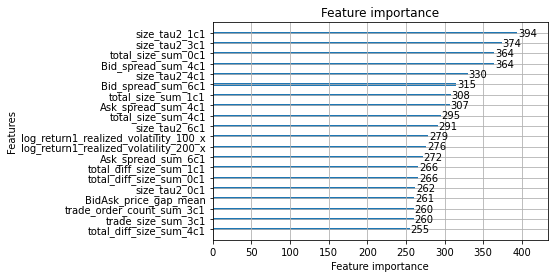

In [25]:
predictions_lgb0= train_and_evaluate_lgb(train, test,params0)

Training fold 1
Training until validation scores don't improve for 30 rounds
[250]	training's rmse: 0.000433251	training's RMSPE: 0.199314	valid_1's rmse: 0.000438898	valid_1's RMSPE: 0.202313
[500]	training's rmse: 0.00041331	training's RMSPE: 0.190141	valid_1's rmse: 0.000422261	valid_1's RMSPE: 0.194644
[750]	training's rmse: 0.000401946	training's RMSPE: 0.184913	valid_1's rmse: 0.000414323	valid_1's RMSPE: 0.190985
[1000]	training's rmse: 0.000393402	training's RMSPE: 0.180982	valid_1's rmse: 0.000408809	valid_1's RMSPE: 0.188443
[1250]	training's rmse: 0.000386967	training's RMSPE: 0.178021	valid_1's rmse: 0.000405176	valid_1's RMSPE: 0.186768
[1500]	training's rmse: 0.000381633	training's RMSPE: 0.175568	valid_1's rmse: 0.00040281	valid_1's RMSPE: 0.185678
[1750]	training's rmse: 0.000377138	training's RMSPE: 0.1735	valid_1's rmse: 0.000400891	valid_1's RMSPE: 0.184793
[2000]	training's rmse: 0.000373211	training's RMSPE: 0.171693	valid_1's rmse: 0.000399827	valid_1's RMSPE: 0.1

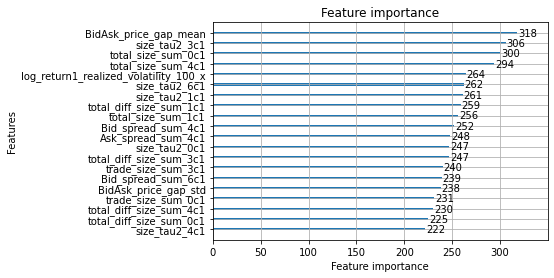

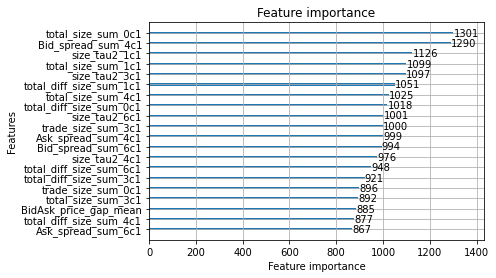

In [26]:
# # Traing and evaluate
# predictions_lgb0= train_and_evaluate_lgb(train, test,params0)
predictions_lgb1= train_and_evaluate_lgb(train, test,params1, boost=10000)
predictions_lgb2= train_and_evaluate_lgb(train, test,params2, boost=10000)
# predictions_lgb3= train_and_evaluate_lgb(train, test,params3, boost=10000)
# predictions_lgb4= train_and_evaluate_lgb(train, test,params4, boost=10000)

In [27]:
# predictions_lgb3= train_and_evaluate_lgb(train, test,params3, boost=10000)
# predictions_lgb4= train_and_evaluate_lgb(train, test,params4, boost=10000)

In [28]:
# test['target'] = predictions_lgb*0.5 + predictions_lgb2*0.5
# preds_lgb = predictions_lgb*0.5 + predictions_lgb2*0.5
# test[['row_id', 'target']].to_csv('submission.csv',index = False)

In [29]:
path_submissions = '/'
target_name = 'target'
scores_folds = {}

In [30]:
from numpy.random import seed
seed(42)
import tensorflow as tf
tf.random.set_seed(42)
from tensorflow import keras
import numpy as np
from keras import backend as K
# kfold based on the knn++ algorithm

out_train = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
out_train = out_train.pivot(index='time_id', columns='stock_id', values='target')

#out_train[out_train.isna().any(axis=1)]
out_train = out_train.fillna(out_train.mean())
out_train.head()

# code to add the just the read data after first execution

# data separation based on knn ++
nfolds = 5 # number of folds
index = []
totDist = []
values = []
# generates a matriz with the values of 
mat = out_train.values

scaler = MinMaxScaler(feature_range=(-1, 1))
mat = scaler.fit_transform(mat)

nind = int(mat.shape[0]/nfolds) # number of individuals

# adds index in the last column
mat = np.c_[mat,np.arange(mat.shape[0])]


lineNumber = np.random.choice(np.array(mat.shape[0]), size=nfolds, replace=False)

lineNumber = np.sort(lineNumber)[::-1]

for n in range(nfolds):
    totDist.append(np.zeros(mat.shape[0]-nfolds))

# saves index
for n in range(nfolds):
    
    values.append([lineNumber[n]])    


s=[]
for n in range(nfolds):
    s.append(mat[lineNumber[n],:])
    
    mat = np.delete(mat, obj=lineNumber[n], axis=0)

for n in range(nind-1):    

    luck = np.random.uniform(0,1,nfolds)
    
    for cycle in range(nfolds):
         # saves the values of index           

        s[cycle] = np.matlib.repmat(s[cycle], mat.shape[0], 1)

        sumDist = np.sum( (mat[:,:-1] - s[cycle][:,:-1])**2 , axis=1)   
        totDist[cycle] += sumDist        
                
        # probabilities
        f = totDist[cycle]/np.sum(totDist[cycle]) # normalizing the totdist
        j = 0
        kn = 0
        for val in f:
            j += val        
            if (j > luck[cycle]): # the column was selected
                break
            kn +=1
        lineNumber[cycle] = kn
        
        # delete line of the value added    
        for n_iter in range(nfolds):
            
            totDist[n_iter] = np.delete(totDist[n_iter],obj=lineNumber[cycle], axis=0)
            j= 0
        
        s[cycle] = mat[lineNumber[cycle],:]
        values[cycle].append(int(mat[lineNumber[cycle],-1]))
        mat = np.delete(mat, obj=lineNumber[cycle], axis=0)


for n_mod in range(nfolds):
    values[n_mod] = out_train.index[values[n_mod]]
def root_mean_squared_per_error(y_true, y_pred):
         return K.sqrt(K.mean(K.square( (y_true - y_pred)/ y_true )))
    
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=20, verbose=0,
    mode='min',restore_best_weights=True)

plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=7, verbose=0,
    mode='min')
colNames = list(train)

colNames.remove('time_id')
colNames.remove('target')
colNames.remove('row_id')
colNames.remove('stock_id')
train.replace([np.inf, -np.inf], np.nan,inplace=True)
test.replace([np.inf, -np.inf], np.nan,inplace=True)
qt_train = []

for col in colNames:
    #print(col)
    qt = QuantileTransformer(random_state=21,n_quantiles=2000, output_distribution='normal')
    train[col] = qt.fit_transform(train[[col]])
    test[col] = qt.transform(test[[col]])    
    qt_train.append(qt)
from sklearn.cluster import KMeans
# making agg features

train_p = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
train_p = train_p.pivot(index='time_id', columns='stock_id', values='target')

corr = train_p.corr()

ids = corr.index

kmeans = KMeans(n_clusters=7, random_state=0).fit(corr.values)
print(kmeans.labels_)

l = []
for n in range(7):
    l.append ( [ (x-1) for x in ( (ids+1)*(kmeans.labels_ == n)) if x > 0] )
    

mat = []
matTest = []

n = 0
for ind in l:
    print(ind)
    newDf = train.loc[train['stock_id'].isin(ind) ]
    newDf = newDf.groupby(['time_id']).agg(np.nanmean)
    newDf.loc[:,'stock_id'] = str(n)+'c1'
    mat.append ( newDf )
    
    newDf = test.loc[test['stock_id'].isin(ind) ]    
    newDf = newDf.groupby(['time_id']).agg(np.nanmean)
    newDf.loc[:,'stock_id'] = str(n)+'c1'
    matTest.append ( newDf )
    
    n+=1
    
mat1 = pd.concat(mat).reset_index()
mat1.drop(columns=['target'],inplace=True)

mat2 = pd.concat(matTest).reset_index()

matTest = []
mat = []
kmeans = []
#mat2 #= mat1.pivot(index='time_id', columns='stock_idmat2
mat2 = pd.concat([mat2,mat1.loc[mat1.time_id==5]])
mat1 = mat1.pivot(index='time_id', columns='stock_id')
mat1.columns = ["_".join(x) for x in mat1.columns.ravel()]
mat1.reset_index(inplace=True)

mat2 = mat2.pivot(index='time_id', columns='stock_id')
mat2.columns = ["_".join(x) for x in mat2.columns.ravel()]
mat2.reset_index(inplace=True)

[1 0 4 2 1 1 2 4 6 2 1 0 4 4 1 1 1 2 4 4 4 0 1 1 3 1 1 4 3 4 3 4 4 1 3 3 4
 3 4 1 4 1 4 4 1 0 4 4 1 0 0 3 3 3 2 0 2 4 1 4 4 1 4 1 0 3 3 0 3 0 6 5 3 3
 0 1 2 0 3 3 3 4 1 1 0 2 3 3 1 0 1 4 4 4 4 4 1 3 1 0 1 4 1 0 1 4 1 0 4 0 4
 0]
[1, 11, 22, 50, 55, 56, 62, 73, 76, 78, 84, 87, 96, 101, 112, 116, 122, 124, 126]
[0, 4, 5, 10, 15, 16, 17, 23, 26, 28, 29, 36, 42, 44, 48, 53, 66, 69, 72, 85, 94, 95, 100, 102, 109, 111, 113, 115, 118, 120]
[3, 6, 9, 18, 61, 63, 86, 97]
[27, 31, 33, 37, 38, 40, 58, 59, 60, 74, 75, 77, 82, 83, 88, 89, 90, 98, 99, 110]
[2, 7, 13, 14, 19, 20, 21, 30, 32, 34, 35, 39, 41, 43, 46, 47, 51, 52, 64, 67, 68, 70, 93, 103, 104, 105, 107, 108, 114, 119, 123, 125]
[81]
[8, 80]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:164: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:168: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.


In [31]:

nnn = ['time_id',
     'log_return1_realized_volatility_0c1',
     'log_return1_realized_volatility_1c1',     
     'log_return1_realized_volatility_3c1',
     'log_return1_realized_volatility_4c1',     
     'log_return1_realized_volatility_6c1',
     'total_diff_size_sum_0c1',
     'total_diff_size_sum_1c1', 
     'total_diff_size_sum_3c1',
     'total_diff_size_sum_4c1', 
     'total_diff_size_sum_6c1',
     'trade_size_sum_0c1',
     'trade_size_sum_1c1', 
     'trade_size_sum_3c1',
     'trade_size_sum_4c1', 
     'trade_size_sum_6c1',
     'trade_order_count_sum_0c1',
     'trade_order_count_sum_1c1',
     'trade_order_count_sum_3c1',
     'trade_order_count_sum_4c1',
     'trade_order_count_sum_6c1',      
     'price_spread_sum_0c1',
     'price_spread_sum_1c1',
     'price_spread_sum_3c1',
     'price_spread_sum_4c1',
     'price_spread_sum_6c1',   
     'Bid_spread_sum_0c1',
     'Bid_spread_sum_1c1',
     'Bid_spread_sum_3c1',
     'Bid_spread_sum_4c1',
     'Bid_spread_sum_6c1',       
     'Ask_spread_sum_0c1',
     'Ask_spread_sum_1c1',
     'Ask_spread_sum_3c1',
     'Ask_spread_sum_4c1',
     'Ask_spread_sum_6c1',   
     'total_size_sum_0c1',
     'total_size_sum_1c1',
     'total_size_sum_3c1',
     'total_size_sum_4c1',
     'total_size_sum_6c1',       
     'BidAskSpread_sum_0c1',
     'BidAskSpread_sum_1c1',
     'BidAskSpread_sum_3c1',
     'BidAskSpread_sum_4c1',
     'BidAskSpread_sum_6c1',
     'size_tau2_0c1',
     'size_tau2_1c1',
     'size_tau2_3c1',
     'size_tau2_4c1',
     'size_tau2_6c1'] 

train = pd.merge(train,mat1[nnn],how='left',on='time_id')
test = pd.merge(test,mat2[nnn],how='left',on='time_id')
mat1= []
mat2= []
train.shape,test.shape

((425102, 382), (3, 381))

In [32]:
#https://bignerdranch.com/blog/implementing-swish-activation-function-in-keras/
from keras.backend import sigmoid
def swish(x, beta = 1):
    return (x * sigmoid(beta * x))

from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation
get_custom_objects().update({'swish': Activation(swish)})
hidden_units = (128,64,32)
stock_embedding_size = 24

cat_data = train['stock_id']

def base_model():
    
    # Each instance will consist of two inputs: a single user id, and a single movie id
    stock_id_input = keras.Input(shape=(1,), name='stock_id')
    num_input = keras.Input(shape=(378,), name='num_data')


    #embedding, flatenning and concatenating
    stock_embedded = keras.layers.Embedding(max(cat_data)+1, stock_embedding_size, 
                                           input_length=1, name='stock_embedding')(stock_id_input)
    stock_flattened = keras.layers.Flatten()(stock_embedded)
    out = keras.layers.Concatenate()([stock_flattened, num_input])
    
    # Add one or more hidden layers
    for n_hidden in hidden_units:

        out = keras.layers.Dense(n_hidden, activation='swish')(out)
        

    #out = keras.layers.Concatenate()([out, num_input])

    # A single output: our predicted rating
    out = keras.layers.Dense(1, activation='linear', name='prediction')(out)
    
    model = keras.Model(
    inputs = [stock_id_input, num_input],
    outputs = out,
    )
    
    return model

In [33]:
# casio
model_name = 'NN'
pred_name = 'pred_{}'.format(model_name)

n_folds = 5
kf = model_selection.KFold(n_splits=n_folds, shuffle=True, random_state=2020)
scores_folds[model_name] = []
counter = 1

features_to_consider = list(train)

features_to_consider.remove('time_id')
features_to_consider.remove('target')
features_to_consider.remove('row_id')
try:
    features_to_consider.remove('pred_NN')
except:
    pass


train[features_to_consider] = train[features_to_consider].fillna(train[features_to_consider].mean())
test[features_to_consider] = test[features_to_consider].fillna(train[features_to_consider].mean())

train[pred_name] = 0
test['target'] = 0


for n_count in range(n_folds):
    print('CV {}/{}'.format(counter, n_folds))
    
    indexes = np.arange(nfolds).astype(int)    
    indexes = np.delete(indexes,obj=n_count, axis=0) 
    
    indexes = np.r_[values[indexes[0]],values[indexes[1]],values[indexes[2]],values[indexes[3]]]
    
    X_train = train.loc[train.time_id.isin(indexes), features_to_consider]
    y_train = train.loc[train.time_id.isin(indexes), target_name]
    X_test = train.loc[train.time_id.isin(values[n_count]), features_to_consider]
    y_test = train.loc[train.time_id.isin(values[n_count]), target_name]
    
    #############################################################################################
    # NN
    #############################################################################################
    
    model = base_model()
    
    model.compile(
        keras.optimizers.Adam(learning_rate=0.0053), #0.005
        loss=root_mean_squared_per_error
    )
    
    try:
        features_to_consider.remove('stock_id')
    except:
        pass
    
    num_data = X_train[features_to_consider]
    
    scaler = MinMaxScaler(feature_range=(-1, 1))         
    num_data = scaler.fit_transform(num_data.values)    
    
    cat_data = X_train['stock_id']    
    target =  y_train
    
    num_data_test = X_test[features_to_consider]
    num_data_test = scaler.transform(num_data_test.values)
    cat_data_test = X_test['stock_id']

    model.fit([cat_data, num_data], 
              target,               
              batch_size=2048,
              epochs=200, # 1000
              validation_data=([cat_data_test, num_data_test], y_test),
              callbacks=[es, plateau],
              validation_batch_size=len(y_test),
              shuffle=True,
             verbose = 1)

    preds = model.predict([cat_data_test, num_data_test]).reshape(1,-1)[0]
    
    score = round(rmspe(y_true = y_test, y_pred = preds),5)
    print('Fold {} {}: {}'.format(counter, model_name, score))
    scores_folds[model_name].append(score)
    
    tt =scaler.transform(test[features_to_consider].values)
    test[target_name] += model.predict([test['stock_id'], tt]).reshape(1,-1)[0].clip(0,1e10)
    #test[target_name] += model.predict([test['stock_id'], test[features_to_consider]]).reshape(1,-1)[0].clip(0,1e10)
       
    counter += 1
    features_to_consider.append('stock_id')

CV 1/5
Epoch 1/200
167/167 [==============================] - 4s 21ms/step - loss: 28.0412 - val_loss: 1.8521
Epoch 2/200
167/167 [==============================] - 3s 16ms/step - loss: 1.1165 - val_loss: 0.6277
Epoch 3/200
167/167 [==============================] - 3s 16ms/step - loss: 0.6174 - val_loss: 0.7320
Epoch 4/200
167/167 [==============================] - 3s 17ms/step - loss: 0.4863 - val_loss: 0.3427
Epoch 5/200
167/167 [==============================] - 3s 16ms/step - loss: 0.2961 - val_loss: 0.4233
Epoch 6/200
167/167 [==============================] - 3s 15ms/step - loss: 0.3078 - val_loss: 0.2599
Epoch 7/200
167/167 [==============================] - 3s 17ms/step - loss: 0.2999 - val_loss: 0.2955
Epoch 8/200
167/167 [==============================] - 3s 16ms/step - loss: 0.3201 - val_loss: 0.2481
Epoch 9/200
167/167 [==============================] - 3s 16ms/step - loss: 0.3368 - val_loss: 0.3068
Epoch 10/200
167/167 [==============================] - 3s 16ms/step - los

In [34]:
pred1_nn=test['target'].copy()

In [35]:
# citizen
model_name = 'NN'
pred_name = 'pred_{}'.format(model_name)

n_folds = 5
kf = model_selection.KFold(n_splits=n_folds, shuffle=True, random_state=29)
scores_folds[model_name] = []
counter = 1

features_to_consider = list(train)

features_to_consider.remove('time_id')
features_to_consider.remove('target')
features_to_consider.remove('row_id')
try:
    features_to_consider.remove('pred_NN')
except:
    pass


train[features_to_consider] = train[features_to_consider].fillna(train[features_to_consider].mean())
test[features_to_consider] = test[features_to_consider].fillna(train[features_to_consider].mean())

train[pred_name] = 0
test['target'] = 0


for n_count in range(n_folds):
    print('CV {}/{}'.format(counter, n_folds))
    
    indexes = np.arange(nfolds).astype(int)    
    indexes = np.delete(indexes,obj=n_count, axis=0) 
    
    indexes = np.r_[values[indexes[0]],values[indexes[1]],values[indexes[2]],values[indexes[3]]]
    
    X_train = train.loc[train.time_id.isin(indexes), features_to_consider]
    y_train = train.loc[train.time_id.isin(indexes), target_name]
    X_test = train.loc[train.time_id.isin(values[n_count]), features_to_consider]
    y_test = train.loc[train.time_id.isin(values[n_count]), target_name]
    
    #############################################################################################
    # NN
    #############################################################################################
    
    model = base_model()
    
    model.compile(
        keras.optimizers.Adam(learning_rate=0.0065), #0.005
        loss=root_mean_squared_per_error
    )
    
    try:
        features_to_consider.remove('stock_id')
    except:
        pass
    
    num_data = X_train[features_to_consider]
    
    scaler = MinMaxScaler(feature_range=(-1, 1))         
    num_data = scaler.fit_transform(num_data.values)    
    
    cat_data = X_train['stock_id']    
    target =  y_train
    
    num_data_test = X_test[features_to_consider]
    num_data_test = scaler.transform(num_data_test.values)
    cat_data_test = X_test['stock_id']

    model.fit([cat_data, num_data], 
              target,               
              batch_size=2048,
              epochs=200, # 1000
              validation_data=([cat_data_test, num_data_test], y_test),
              callbacks=[es, plateau],
              validation_batch_size=len(y_test),
              shuffle=True,
             verbose = 1)

    preds = model.predict([cat_data_test, num_data_test]).reshape(1,-1)[0]
    
    score = round(rmspe(y_true = y_test, y_pred = preds),5)
    print('Fold {} {}: {}'.format(counter, model_name, score))
    scores_folds[model_name].append(score)
    
    tt =scaler.transform(test[features_to_consider].values)
    test[target_name] += model.predict([test['stock_id'], tt]).reshape(1,-1)[0].clip(0,1e10)
    #test[target_name] += model.predict([test['stock_id'], test[features_to_consider]]).reshape(1,-1)[0].clip(0,1e10)
       
    counter += 1
    features_to_consider.append('stock_id')
pred2_nn=test['target'].copy()

CV 1/5
Epoch 1/200
167/167 [==============================] - 3s 16ms/step - loss: 39.2146 - val_loss: 5.5275
Epoch 2/200
167/167 [==============================] - 2s 15ms/step - loss: 2.9821 - val_loss: 1.9761
Epoch 3/200
167/167 [==============================] - 2s 15ms/step - loss: 1.2329 - val_loss: 0.8722
Epoch 4/200
167/167 [==============================] - 3s 15ms/step - loss: 0.7904 - val_loss: 0.5874
Epoch 5/200
167/167 [==============================] - 2s 15ms/step - loss: 0.6611 - val_loss: 0.2252
Epoch 6/200
167/167 [==============================] - 3s 15ms/step - loss: 0.3105 - val_loss: 0.8806
Epoch 7/200
167/167 [==============================] - 3s 16ms/step - loss: 1.5177 - val_loss: 0.3629
Epoch 8/200
167/167 [==============================] - 2s 15ms/step - loss: 0.2892 - val_loss: 0.2856
Epoch 9/200
167/167 [==============================] - 3s 16ms/step - loss: 0.3004 - val_loss: 0.3104
Epoch 10/200
167/167 [==============================] - 3s 18ms/step - los

In [36]:
# # rolex
# model_name = 'NN'
# pred_name = 'pred_{}'.format(model_name)

# n_folds = 4
# kf = model_selection.KFold(n_splits=n_folds, shuffle=True, random_state=29)
# scores_folds[model_name] = []
# counter = 1

# features_to_consider = list(train)

# features_to_consider.remove('time_id')
# features_to_consider.remove('target')
# features_to_consider.remove('row_id')
# try:
#     features_to_consider.remove('pred_NN')
# except:
#     pass


# train[features_to_consider] = train[features_to_consider].fillna(train[features_to_consider].mean())
# test[features_to_consider] = test[features_to_consider].fillna(train[features_to_consider].mean())

# train[pred_name] = 0
# test['target'] = 0


# for n_count in range(n_folds):
#     print('CV {}/{}'.format(counter, n_folds))
    
#     indexes = np.arange(nfolds).astype(int)    
#     indexes = np.delete(indexes,obj=n_count, axis=0) 
    
#     indexes = np.r_[values[indexes[0]],values[indexes[1]],values[indexes[2]],values[indexes[3]]]
    
#     X_train = train.loc[train.time_id.isin(indexes), features_to_consider]
#     y_train = train.loc[train.time_id.isin(indexes), target_name]
#     X_test = train.loc[train.time_id.isin(values[n_count]), features_to_consider]
#     y_test = train.loc[train.time_id.isin(values[n_count]), target_name]
    
#     #############################################################################################
#     # NN
#     #############################################################################################
    
#     model = base_model()
    
#     model.compile(
#         keras.optimizers.Adam(learning_rate=0.001), #0.005
#         loss=root_mean_squared_per_error
#     )
    
#     try:
#         features_to_consider.remove('stock_id')
#     except:
#         pass
    
#     num_data = X_train[features_to_consider]
    
#     scaler = MinMaxScaler(feature_range=(-1, 1))         
#     num_data = scaler.fit_transform(num_data.values)    
    
#     cat_data = X_train['stock_id']    
#     target =  y_train
    
#     num_data_test = X_test[features_to_consider]
#     num_data_test = scaler.transform(num_data_test.values)
#     cat_data_test = X_test['stock_id']

#     model.fit([cat_data, num_data], 
#               target,               
#               batch_size=2048,
#               epochs=200, # 1000
#               validation_data=([cat_data_test, num_data_test], y_test),
#               callbacks=[es, plateau],
#               validation_batch_size=len(y_test),
#               shuffle=True,
#              verbose = 1)

#     preds = model.predict([cat_data_test, num_data_test]).reshape(1,-1)[0]
    
#     score = round(rmspe(y_true = y_test, y_pred = preds),5)
#     print('Fold {} {}: {}'.format(counter, model_name, score))
#     scores_folds[model_name].append(score)
    
#     tt =scaler.transform(test[features_to_consider].values)
#     test[target_name] += model.predict([test['stock_id'], tt]).reshape(1,-1)[0].clip(0,1e10)
#     #test[target_name] += model.predict([test['stock_id'], test[features_to_consider]]).reshape(1,-1)[0].clip(0,1e10)
       
#     counter += 1
#     features_to_consider.append('stock_id')
# pred3_nn=test['target'].copy()

In [37]:
# test['target'] = predictions_lgb*0.5 + predictions_lgb2*0.5
# preds_lgb = predictions_lgb*0.5 + predictions_lgb2*0.5
# test[['row_id', 'target']].to_csv('submission.csv',index = False)

In [38]:
# predictions_lgb0= train_and_evaluate_lgb(train, test,params0)
# predictions_lgb1= train_and_evaluate_lgb(train, test,params1, boost=10000)
# predictions_lgb2= train_and_evaluate_lgb(train, test,params2, boost=10000)
# predictions_lgb3= train_and_evaluate_lgb(train, test,params3, boost=10000)
# predictions_lgb4= train_and_evaluate_lgb(train, test,params4, boost=10000)
# pred3_nn=pred3_nn/4
pred2_nn=pred2_nn/5
pred1_nn=pred1_nn/5
# preds_nn = (pred2_nn*0.4+pred1_nn*0.4+pred3_nn*0.2)
# preds_nn
# test['target'] = preds_lgb*0.4 + preds_nn*0.6

In [39]:

# test['target'] = pred2_nn*0.3 + pred1_nn*0.3 +\
# #                  pred3_nn*0.1 +\
#                  predictions_lgb0*0.05 + \
#                  predictions_lgb1*0.25 + predictions_lgb2*0.05
# + predictions_lgb3*0.05 + predictions_lgb4*0.05
test['target'] = pred2_nn*0.3 + pred1_nn*0.3 + predictions_lgb0*0.05 + predictions_lgb1*0.3 + predictions_lgb2*0.05 
# test['target'] = preds_nn
test[['row_id', 'target']].to_csv('submission.csv',index = False)
# test[['row_id', 'target']]
# test[['row_id', 'target']].to_csv('submission.csv',index = False)